In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 1
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 200, 2000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 201)
y_integers = y_dense[np.linspace(0, 1999, 200, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/25).astype(int)
group_names = [f"第{i+1}组" for i in range(8)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#f5fa07', '#07faec', '#f808b9']  # 8种不同颜色
for group in range(8):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999870059+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


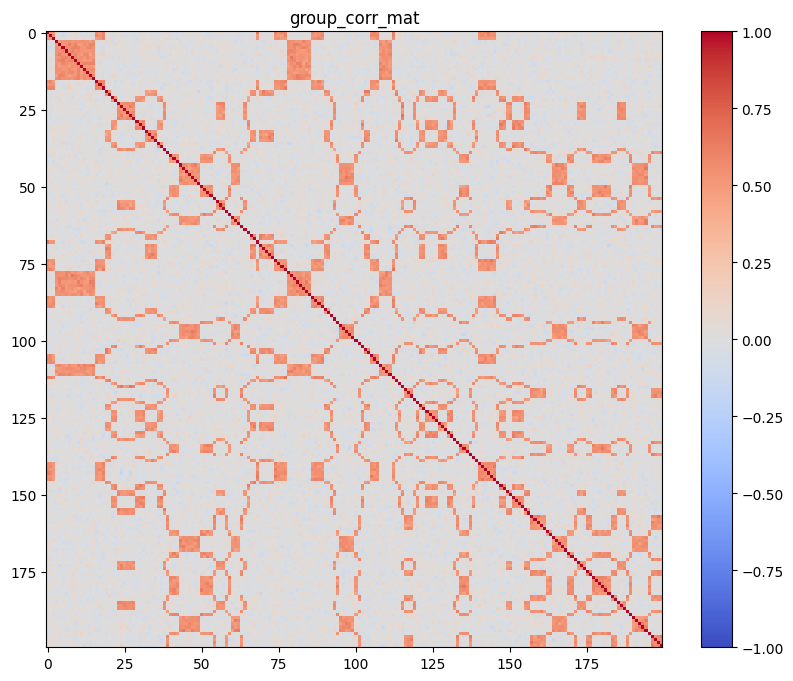

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 200
within_group_mean = 0.7
between_group_mean = 0.0
noise_std = 0.1 

np.random.seed(seed=seed)

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
group_labels+1

array([2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4,
       4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 4, 4, 5, 6, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 5, 5, 5, 6, 7, 8, 8, 8, 6, 5, 4,
       3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 4, 5, 7, 8, 8, 8, 8, 8, 7, 6, 4, 3, 3, 2, 2, 2, 1, 1,
       1, 1, 2, 3, 4, 5, 6, 6, 6, 5, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4,
       5, 6, 7, 7, 7, 6, 4, 3, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 5, 4, 4, 4,
       4, 5, 5, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8, 7, 7, 6, 5, 5, 5, 6,
       6, 7, 7, 7, 7, 7, 7, 6, 6, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8, 7, 6, 6,
       6, 6])

验证结果:
方差范围: 26.53-131.92 (目标: 25-144)
最小特征值: 0.000000 (应>0)


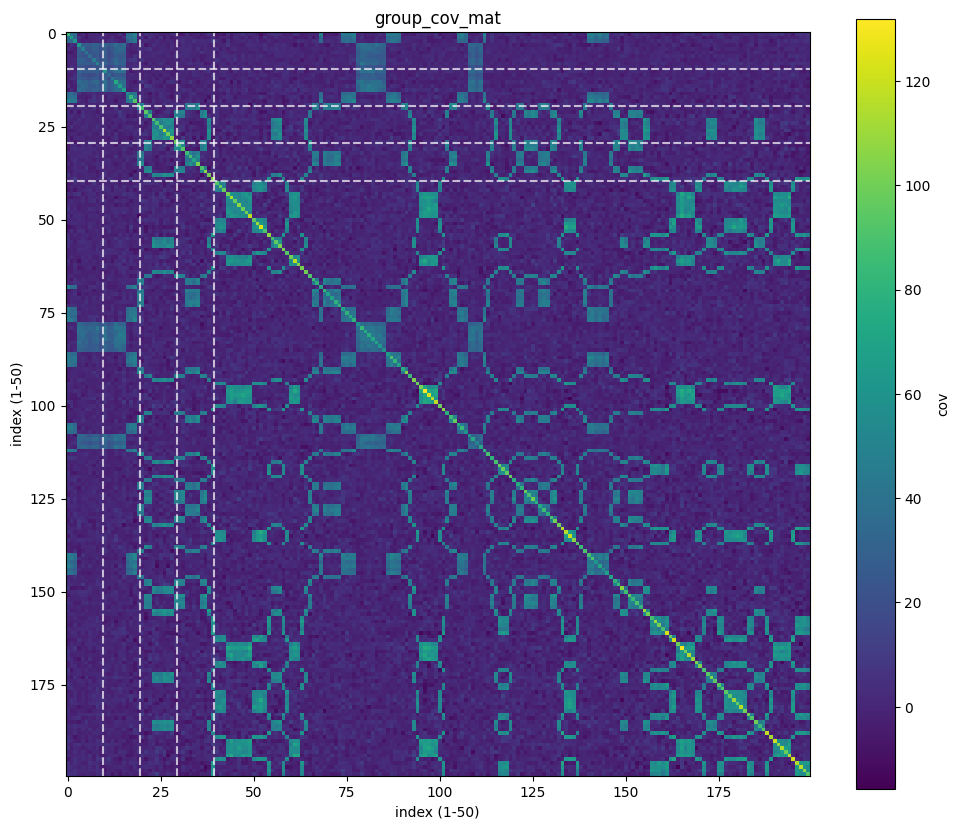

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
y_integers

array([64.48639467, 63.0278422 , 61.8131853 , 60.43562785, 58.9272491 ,
       57.15896591, 55.31619101, 53.71290238, 52.88103571, 52.83362215,
       53.71497558, 55.05149272, 56.59067759, 58.11176505, 59.34555778,
       60.66926213, 61.8496196 , 63.12635976, 64.4044586 , 65.79515469,
       67.12988978, 68.31274244, 69.1733974 , 69.72324672, 69.94893993,
       69.81090756, 69.69089088, 69.61474924, 69.39553807, 68.96986547,
       68.30473047, 67.40062086, 66.63781185, 66.14015128, 66.06441985,
       66.53567675, 67.43099991, 68.55319854, 69.83780174, 71.09156073,
       71.96957079, 72.59860233, 72.95357963, 73.24060467, 73.42056462,
       73.57888124, 73.62836434, 73.58441557, 73.49047862, 73.29980631,
       73.14419921, 73.09651732, 72.70880601, 72.009316  , 71.05499745,
       70.10095219, 69.62747446, 69.8911378 , 70.91959347, 72.20915776,
       73.30553875, 73.69930884, 73.17864744, 71.83398776, 70.01256352,
       68.029229  , 66.41284623, 65.35585732, 65.10958616, 65.43

In [7]:
variances

array([ 83.9974688 ,  67.8333685 ,  61.00988165,  64.344691  ,
        49.16234749,  41.64311916,  36.85455279,  47.27327917,
        51.2922804 ,  26.52601467,  59.38299142,  34.46203384,
        44.44786602,  74.96985244,  68.83165461,  67.6769777 ,
        55.98365517,  82.7683133 ,  91.62911688,  85.69086767,
        88.93770315,  94.73507768,  89.50992193,  93.61531531,
        86.91809211,  90.38888664, 115.88380607,  98.25108652,
       106.10516462,  98.152914  ,  84.89630256,  93.01732413,
        86.34446618,  89.03320101,  72.26920948, 102.47987868,
        90.5949734 , 105.99819715, 100.03880627, 105.34636646,
        92.12467527,  97.41391917,  97.57830973, 101.05429816,
       114.56263617,  97.14334136, 107.04633602,  99.42326974,
       101.262277  , 117.78262327,  95.30000824, 111.11763306,
       124.69258234,  91.1531935 , 106.98693661,  88.3663272 ,
        96.12951997, 102.96355674, 103.07609966,  93.80913351,
       100.55783988, 117.79675661, 105.10767605, 102.45